In [1]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Conv2DTranspose, Flatten, Dropout, ReLU, Input, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

LOAD DATABASES, CONCATENATE AND MIX THEM

In [2]:
def load_data():
    rv = [54.]
    nr = len(rv) 
    
    def load_and_shuffle_dbs(rv):
        paths = []
        for r in rv:
            paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
        
        n_traj = 50000
        db = np.ndarray(shape=(nr*n_traj,2000,1))
        labels = []
        for path,r,i in zip(paths,rv,range(nr)):
            db1 = np.load(path)
            for j in range(n_traj):
                db[i*n_traj + j,:,0] = db1[j,0,:]
                labels.append(r)
        
        labels = np.array(labels)
        
        def unison_shuffled_copies(a, b):
            assert len(a) == len(b)
            p = np.random.permutation(len(a))
            return a[p], b[p]
        
        db, labels = unison_shuffled_copies(db, labels)
        return db, labels
    

    db, labels = load_and_shuffle_dbs(rv)
    
    
    
    
    
    validation_split = 0.1
    
    sig_len = len(db[0,:,0])
    print(f"siglen: {sig_len}")
    channels = 1 #len(db[0,0,:])
    print(f"channels: {channels}")
    n_traj = len(db[:,0,0])
    print((f"n_traj: {n_traj}"))
    # numero della prima traiettoria usata come validation
    first_validation = round((1. - validation_split)*n_traj)
    print(f"first_validation: {first_validation}")
    db_train = np.ndarray(shape=(first_validation,sig_len,channels))
    db_test = np.ndarray(shape=(n_traj-first_validation,sig_len,channels))
    db_train = db[:first_validation,:,0:channels]
    db_test = db[first_validation:,:,0:channels]
    del db
    
    print(db_train.shape)
    M = np.max(np.append(db_train, db_test))
    m = np.min(np.append(db_train, db_test))
    print(M,m)
    db_train = (db_train - m)/(M - m)
    db_test = (db_test - m)/(M - m)
    M = np.max(db_train)
    m = np.min(db_train)
    print(M,m)
    
    return db_train, db_test

db_train, db_test = load_data()

siglen: 2000
channels: 1
n_traj: 50000
first_validation: 45000
(45000, 2000, 1)
31.27666666957781 -31.28223237314301
1.0 0.0


In [9]:
class WGAN():
    def __init__(self):
        self.d_losses = []
        self.g_losses = []
        self.d_losses_tests  = []
        self.real_critics = []
        self.fake_critics = []
        self.sig_len = 2000
        self.channels = 1
        self.noise_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.2
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss, optimizer=optimizer)

        # Build the generator
        self.gen = self.build_generator()

        self.critic.trainable = False
        gan_input = Input(shape=(self.noise_dim,))
        fake_traj = self.gen(gan_input)
        gan_output = self.critic(fake_traj)
        #K.clear_session()
        self.gan = Model(gan_input, gan_output)
        self.gan.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        fs = (20,1) # dimensione filtro
        fm = 4 # numero filtri
        init_sigma = 0.2 # varianza distribuzione parametri iniziali dei kernel
        mean_init = 0.03
        alpha = 0.3
        #K.clear_session()
        generator = Sequential()
        # Starting size
        d = 5
        #4x1
        generator.add(Dense(d*fm, kernel_initializer=RandomNormal(mean_init, init_sigma), input_dim=(self.noise_dim)))
        generator.add(ReLU(negative_slope=alpha))
        #20x1
        generator.add(Reshape((d, 1, fm)))
        #5x4
        generator.add(Conv2DTranspose(fm, fs, strides=(5,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
        generator.add(ReLU(negative_slope=alpha))
        #50x4
        generator.add(Conv2DTranspose(fm, fs, strides=(5,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
        generator.add(ReLU(negative_slope=alpha))
        #250x4
        generator.add(Conv2DTranspose(fm, fs, strides=(4,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
        generator.add(ReLU(negative_slope=alpha))
        #2000x1
        generator.add(Conv2DTranspose(1, fs, strides=(4,1), padding='same', kernel_initializer=RandomNormal(mean_init, init_sigma)))
        generator.add(Reshape((2000, 1)))
        #generator.summary()
        return generator

    def build_critic(self):
        fs = 20 # dimensione filtro
        fm = 4 # numero filtri
        sigma_init = 0.2 # varianza distribuzione parametri iniziali dei kernel
        mean_init = 0.0
        #K.clear_session()
        discriminator = Sequential()
        #2000x1
        discriminator.add(Conv1D(fm, fs, strides=4, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(self.sig_len, self.channels)))
        discriminator.add(ReLU())
        #250x4
        discriminator.add(Conv1D(fm, fs, strides=4, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
        discriminator.add(ReLU())
        #50x4
        discriminator.add(Conv1D(fm, fs, strides=5, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
        discriminator.add(ReLU())
        #25x4
        discriminator.add(Conv1D(fm, fs, strides=5, padding='same', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
        discriminator.add(ReLU())
        #5x4
        discriminator.add(Flatten())
        #20x1
        #discriminator.add(Dense(4*fm, activation='relu'))
        #64x1
        discriminator.add(Dense(1))
        #1x1
        #discriminator.summary()
        return discriminator

    def plot_trajs(self, gen_trajs):
        plt.figure(figsize=(18, 2))
        for i, traj in enumerate(gen_trajs):
            plt.subplot(1, 1, i+1)
            plt.plot(traj)
            #plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    
    def plot_disc_predictions(self, fake_disc, real_disc, batch_size=250):
        plt.plot(real_disc, label='real')
        plt.plot(fake_disc, label='fake')
        plt.legend()
        plt.show()
    
    def plot_training(self):
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
        ax1.set_xlabel('epochs')
        ax2.set_xlabel('epochs')
        ax1.set_title('Losses')
        ax2.set_title('Critic predictions')
        ax1.plot(self.d_losses, label='critic loss')
        ax1.plot(self.d_losses_tests, label='critic loss on test')
        ax1.plot(self.g_losses, label='generator loss')
        fake_critic = [a[0] for a in self.fake_critics]
        fake_critice = [a[1] for a in self.fake_critics]
        real_critic = [a[0] for a in self.real_critics]
        real_critice = [a[1] for a in self.real_critics]
        n_epochs = len(fake_critic)
        l, caps, c = ax2.errorbar(range(n_epochs), fake_critic, fake_critice, lw=0, marker='^', ms=4, elinewidth=1, uplims=True, lolims=True, capsize=2, label='fake')
        for cap in caps:
            cap.set_marker("_")
        l, caps, c = ax2.errorbar(range(n_epochs), real_critic, real_critice, lw=0, marker='^', ms=4, elinewidth=1, uplims=True, lolims=True, capsize=2, label='real')
        for cap in caps:
            cap.set_marker("_")
            
        ax1.legend()
        ax2.legend()
        plt.show()

    def train(self, epochs, db_train, db_test, batch_size=250):
        
        static_noise = np.random.normal(0, 1, size=(1, self.noise_dim))
        mini_batch_size = batch_size * self.n_critic
        len_data = len(db_train[:,0,0])
        len_test_data = len(db_test[:,0,0])
        steps_per_epoch = len_data // (mini_batch_size)
        valid = -np.ones(batch_size)
        valid_test = -np.ones(len_test_data)
        fake  =  np.ones(batch_size)
        disc_labels = np.concatenate((valid, fake))
        
        for epoch in range(epochs):
            for ii in range(len_data // mini_batch_size):
                
                real_trajs = db_train[np.arange(ii*mini_batch_size, (ii+1)*mini_batch_size)]
                noise = np.random.normal(0, 1, size=(mini_batch_size, self.noise_dim))
                fake_trajs = self.gen.predict(noise)
                for jj in range(self.n_critic):
                    
                    trajs = np.concatenate((real_trajs[jj*batch_size:(jj+1)*batch_size],
                                            fake_trajs[jj*batch_size:(jj+1)*batch_size]))
                    d_loss = self.critic.train_on_batch(trajs, disc_labels)
                    
                    # Clip critic weights
                    for l in self.critic.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                        l.set_weights(weights)
                    
                noise = np.random.normal(0, 1, size=(batch_size, self.noise_dim))
                g_loss = self.gan.train_on_batch(noise, valid)
                print(f'{ii}/{len_data // mini_batch_size}', end='\r')
    
            d_loss_test = self.critic.test_on_batch(db_test,valid_test)
            n = round(np.random.uniform(0,len_data-batch_size))
            real_critic = self.critic.predict(db_train[n:n+batch_size])
            sample_gen = self.gen.predict(noise)
            fake_critic = self.critic.predict(sample_gen)
            if epoch%5==0:
                sample_gen = self.gen.predict(static_noise)
                self.plot_trajs(sample_gen)
                self.plot_disc_predictions(fake_critic, real_critic, batch_size)
            
            real_critic = [np.mean(real_critic), np.std(real_critic)]
            fake_critic = [np.mean(fake_critic), np.std(fake_critic)]
            self.g_losses.append(g_loss)
            self.d_losses.append(d_loss)
            self.d_losses_tests.append(d_loss_test)
            self.real_critics.append(real_critic)
            self.fake_critics.append(fake_critic)
            print (f"epoch: {epoch} [D loss: {d_loss:.4f}] [D loss test: {d_loss_test:.4f}] [G loss: {g_loss:.4f}] [D accuracy: {(real_critic[0]-fake_critic[0])/np.max([real_critic[1],fake_critic[1]]):.4f}]")

wgan = WGAN()

W0430 18:53:09.530593 47610673188352 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


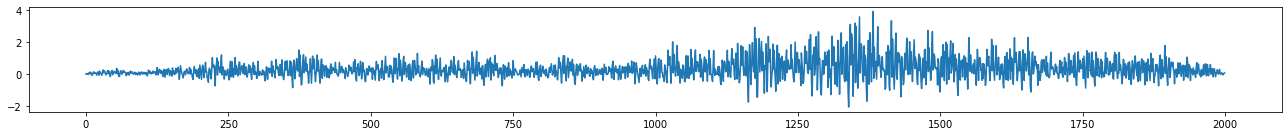

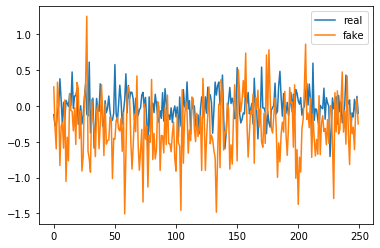

epoch: 0 [D loss: -0.1424] [D loss test: 0.0114] [G loss: 0.2978] [D accuracy: 0.6675]
epoch: 1 [D loss: -0.3411] [D loss test: 0.2644] [G loss: 1.0097] [D accuracy: 1.0200]
epoch: 2 [D loss: -0.8389] [D loss test: 0.4637] [G loss: 2.1484] [D accuracy: 1.3845]
epoch: 3 [D loss: -1.7375] [D loss test: 0.5262] [G loss: 3.5160] [D accuracy: 1.6886]
epoch: 4 [D loss: -2.8155] [D loss test: 0.4930] [G loss: 6.2007] [D accuracy: 1.7886]


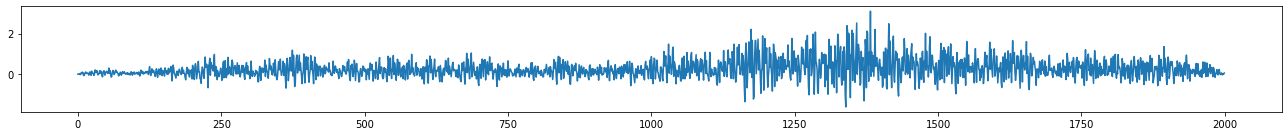

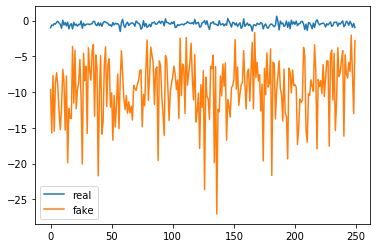

epoch: 5 [D loss: -4.5492] [D loss test: 0.5073] [G loss: 9.6003] [D accuracy: 2.1088]
epoch: 6 [D loss: -7.1911] [D loss test: 0.6195] [G loss: 14.8366] [D accuracy: 2.1871]
epoch: 7 [D loss: -10.6305] [D loss test: 0.7885] [G loss: 23.2584] [D accuracy: 2.1238]
epoch: 8 [D loss: -15.7880] [D loss test: 1.1153] [G loss: 34.2901] [D accuracy: 2.2408]
epoch: 9 [D loss: -22.4201] [D loss test: 1.5437] [G loss: 46.8946] [D accuracy: 2.4176]


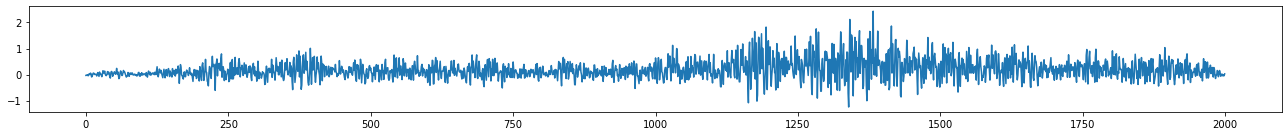

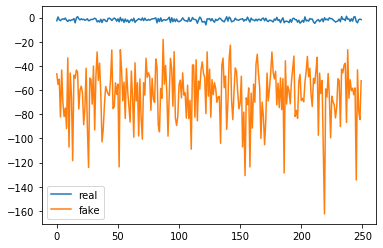

epoch: 10 [D loss: -28.7100] [D loss test: 2.0251] [G loss: 63.6111] [D accuracy: 2.7103]
epoch: 11 [D loss: -40.4991] [D loss test: 2.4130] [G loss: 85.9617] [D accuracy: 2.9197]
epoch: 12 [D loss: -53.6254] [D loss test: 2.6003] [G loss: 111.4645] [D accuracy: 2.9434]
epoch: 13 [D loss: -72.7205] [D loss test: 2.6739] [G loss: 146.9449] [D accuracy: 3.2401]
epoch: 14 [D loss: -92.6807] [D loss test: 2.1390] [G loss: 185.8133] [D accuracy: 3.8829]


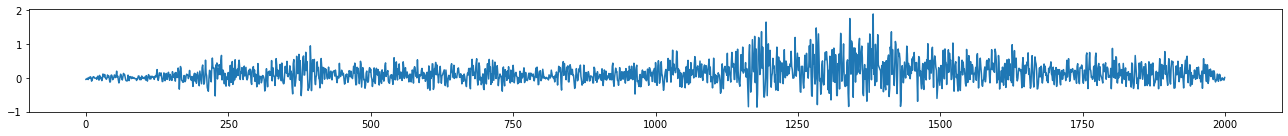

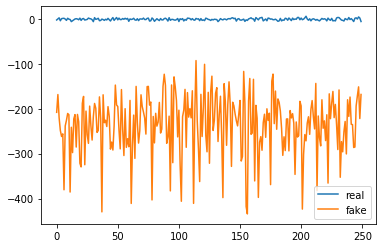

epoch: 15 [D loss: -120.2600] [D loss test: 1.2383] [G loss: 236.1286] [D accuracy: 3.5220]
epoch: 16 [D loss: -147.0702] [D loss test: -0.5099] [G loss: 309.3106] [D accuracy: 3.7841]
epoch: 17 [D loss: -187.3885] [D loss test: -3.5794] [G loss: 382.8036] [D accuracy: 4.2250]
epoch: 18 [D loss: -230.0857] [D loss test: -9.5018] [G loss: 459.2214] [D accuracy: 4.6779]
epoch: 19 [D loss: -277.3280] [D loss test: -20.4786] [G loss: 547.8917] [D accuracy: 5.1873]


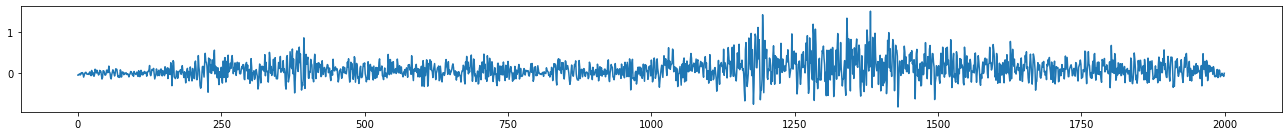

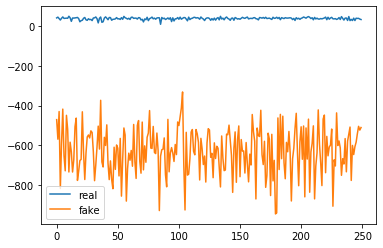

epoch: 20 [D loss: -336.8512] [D loss test: -36.8368] [G loss: 628.6293] [D accuracy: 5.6891]
epoch: 21 [D loss: -406.9925] [D loss test: -60.6961] [G loss: 773.7159] [D accuracy: 5.3941]
epoch: 22 [D loss: -486.7898] [D loss test: -94.2594] [G loss: 869.7632] [D accuracy: 6.0112]
epoch: 23 [D loss: -576.8298] [D loss test: -139.4569] [G loss: 999.6953] [D accuracy: 7.3897]
epoch: 24 [D loss: -674.3785] [D loss test: -202.2511] [G loss: 1157.5193] [D accuracy: 8.8022]


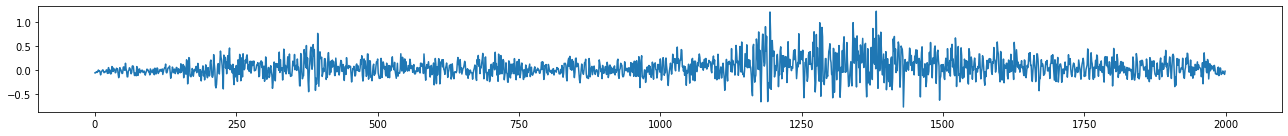

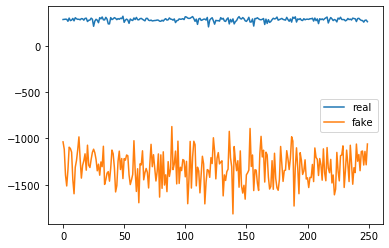

epoch: 25 [D loss: -797.4545] [D loss test: -283.3257] [G loss: 1313.4907] [D accuracy: 9.4309]
epoch: 26 [D loss: -939.4697] [D loss test: -384.3958] [G loss: 1494.7708] [D accuracy: 11.0437]
epoch: 27 [D loss: -1096.6237] [D loss test: -510.5453] [G loss: 1667.8105] [D accuracy: 11.9976]
epoch: 28 [D loss: -1271.2174] [D loss test: -666.8287] [G loss: 1893.6777] [D accuracy: 15.2467]
epoch: 29 [D loss: -1489.5502] [D loss test: -863.9313] [G loss: 2125.9414] [D accuracy: 17.3075]


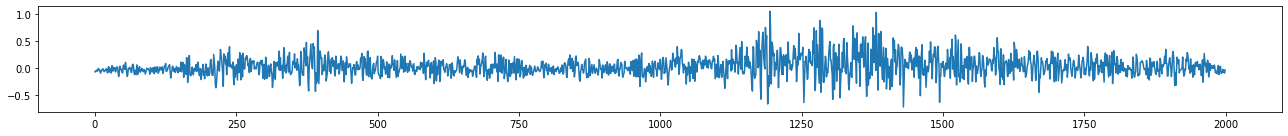

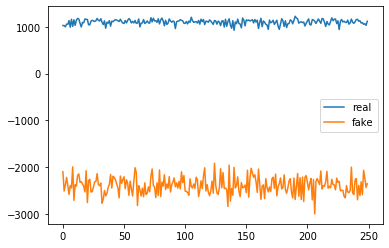

epoch: 30 [D loss: -1731.6866] [D loss test: -1101.5962] [G loss: 2393.4978] [D accuracy: 18.9709]
epoch: 31 [D loss: -2019.9691] [D loss test: -1382.3160] [G loss: 2662.8848] [D accuracy: 24.1856]
epoch: 32 [D loss: -2332.5007] [D loss test: -1711.6823] [G loss: 2959.9236] [D accuracy: 27.1929]
epoch: 33 [D loss: -2677.1038] [D loss test: -2094.6465] [G loss: 3293.3545] [D accuracy: 26.5576]
epoch: 34 [D loss: -3087.8420] [D loss test: -2533.6399] [G loss: 3647.0215] [D accuracy: 24.6768]


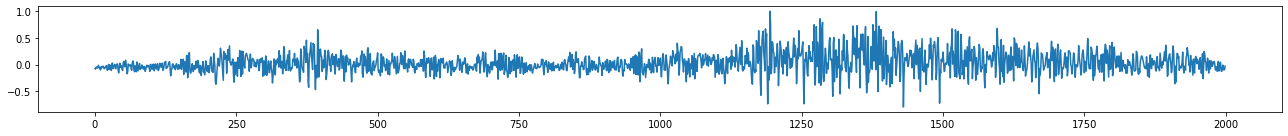

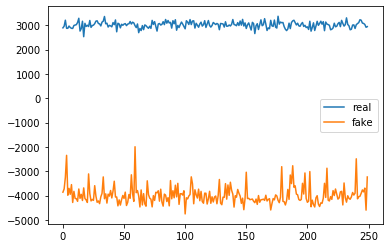

epoch: 35 [D loss: -3491.3406] [D loss test: -3020.1667] [G loss: 3988.6836] [D accuracy: 18.4323]
epoch: 36 [D loss: -3968.2366] [D loss test: -3559.6355] [G loss: 4371.6260] [D accuracy: 13.7664]
epoch: 37 [D loss: -4397.1118] [D loss test: -4148.7710] [G loss: 4734.4214] [D accuracy: 8.6814]
epoch: 38 [D loss: -4883.6392] [D loss test: -4789.7368] [G loss: 5019.9268] [D accuracy: 7.8267]
epoch: 39 [D loss: -5308.0117] [D loss test: -5482.8950] [G loss: 5203.8657] [D accuracy: 5.2596]


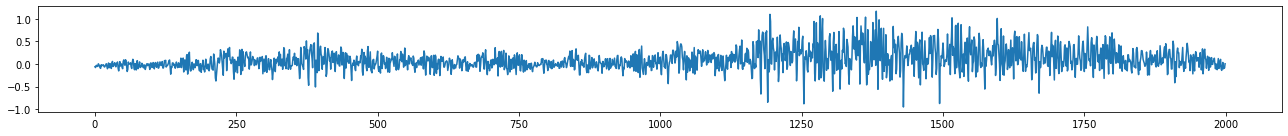

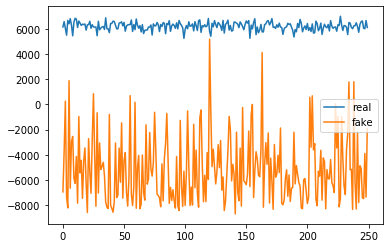

epoch: 40 [D loss: -5852.8481] [D loss test: -6229.7817] [G loss: 5174.3989] [D accuracy: 4.2952]
epoch: 41 [D loss: -6215.2710] [D loss test: -7021.5986] [G loss: 5303.8081] [D accuracy: 3.3744]
epoch: 42 [D loss: -6517.0942] [D loss test: -7865.8174] [G loss: 5566.5259] [D accuracy: 2.9450]
epoch: 43 [D loss: -7085.8320] [D loss test: -8771.3418] [G loss: 4932.3838] [D accuracy: 2.6315]
epoch: 44 [D loss: -6532.7803] [D loss test: -9712.9619] [G loss: 4154.4131] [D accuracy: 2.1899]


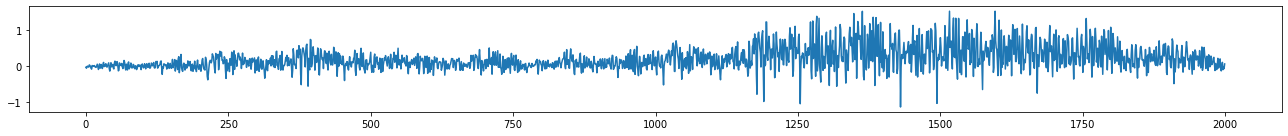

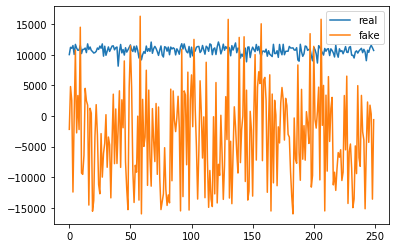

epoch: 45 [D loss: -7298.3154] [D loss test: -10703.4775] [G loss: 3522.1128] [D accuracy: 1.8415]
epoch: 46 [D loss: -6996.6431] [D loss test: -11643.4092] [G loss: 1588.3936] [D accuracy: 1.4128]
epoch: 47 [D loss: -7140.8481] [D loss test: -12519.2559] [G loss: 1552.6532] [D accuracy: 1.3550]
epoch: 48 [D loss: -6631.9385] [D loss test: -13208.6553] [G loss: -141.8668] [D accuracy: 1.0368]
epoch: 49 [D loss: -5998.7031] [D loss test: -13524.7061] [G loss: -802.6079] [D accuracy: 0.8875]


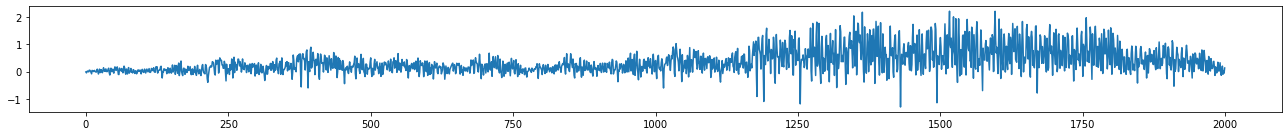

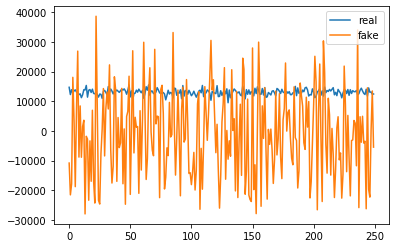

epoch: 50 [D loss: -6901.4800] [D loss test: -13108.3350] [G loss: 1498.5143] [D accuracy: 0.9822]
epoch: 51 [D loss: -6247.5449] [D loss test: -11542.1836] [G loss: 648.2892] [D accuracy: 0.7821]
epoch: 52 [D loss: -4999.1309] [D loss test: -8478.0205] [G loss: 4113.5825] [D accuracy: 0.7365]
epoch: 53 [D loss: -7383.9946] [D loss test: 1451.6771] [G loss: 15924.3291] [D accuracy: 1.1528]
epoch: 54 [D loss: -9861.2051] [D loss test: 12345.1816] [G loss: 31926.5195] [D accuracy: 4.3779]


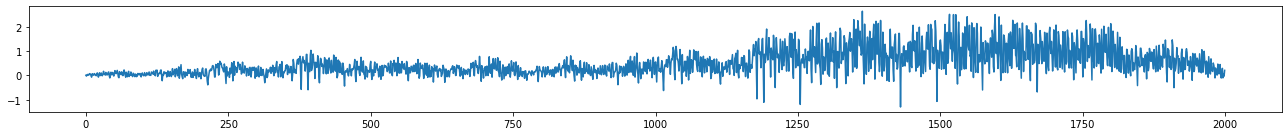

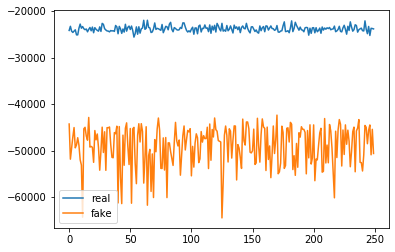

epoch: 55 [D loss: -12629.7324] [D loss test: 23808.9434] [G loss: 49123.7930] [D accuracy: 5.7554]
epoch: 56 [D loss: -15519.6973] [D loss test: 34212.0352] [G loss: 64650.7617] [D accuracy: 2.6566]
epoch: 57 [D loss: -18055.8398] [D loss test: 42324.7734] [G loss: 77293.5078] [D accuracy: 2.1451]
epoch: 58 [D loss: -19586.8535] [D loss test: 46398.6562] [G loss: 84875.2734] [D accuracy: 2.1769]
epoch: 59 [D loss: -20014.0449] [D loss test: 48269.0586] [G loss: 90162.2969] [D accuracy: 2.5721]


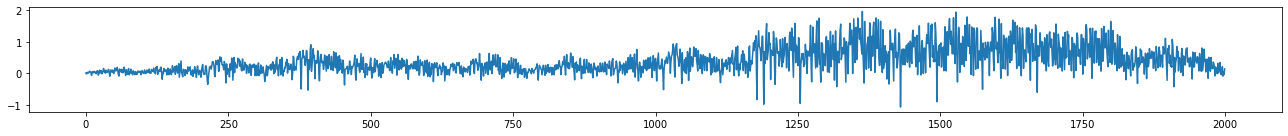

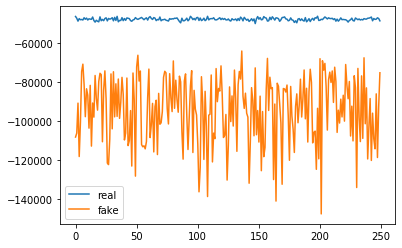

epoch: 60 [D loss: -22633.6230] [D loss test: 47466.5664] [G loss: 94473.1328] [D accuracy: 2.7745]
epoch: 61 [D loss: -24524.1602] [D loss test: 46772.0195] [G loss: 94684.3672] [D accuracy: 3.2750]
epoch: 62 [D loss: -26305.5312] [D loss test: 44993.3828] [G loss: 98304.3984] [D accuracy: 3.6168]
epoch: 63 [D loss: -27978.8867] [D loss test: 41398.7500] [G loss: 97629.3594] [D accuracy: 5.0777]
epoch: 64 [D loss: -29064.3047] [D loss test: 36633.6680] [G loss: 94721.7266] [D accuracy: 7.7098]


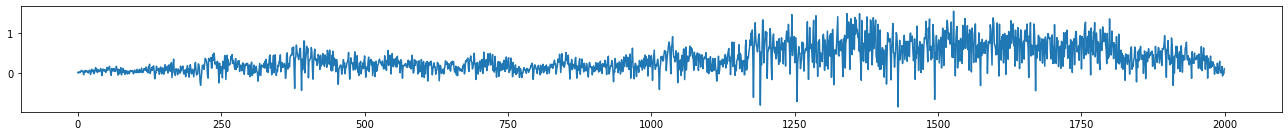

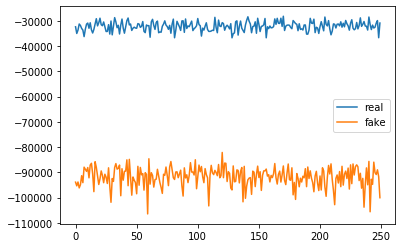

epoch: 65 [D loss: -29709.2637] [D loss test: 32008.3320] [G loss: 92013.8047] [D accuracy: 15.1529]
epoch: 66 [D loss: -30772.2715] [D loss test: 29659.1230] [G loss: 91125.6328] [D accuracy: 25.3252]
epoch: 67 [D loss: -31172.6152] [D loss test: 30848.4102] [G loss: 93329.3438] [D accuracy: 23.2012]
epoch: 68 [D loss: -31680.7617] [D loss test: 36873.1758] [G loss: 100956.1953] [D accuracy: 16.2763]
epoch: 69 [D loss: -31992.8105] [D loss test: 43702.4648] [G loss: 107107.5859] [D accuracy: 12.3838]


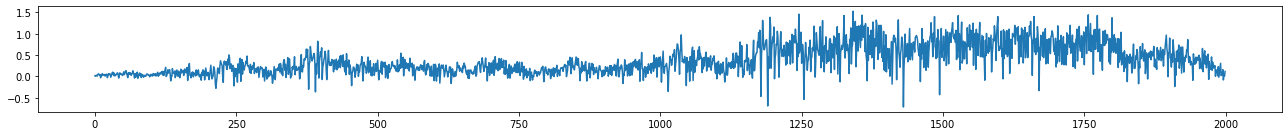

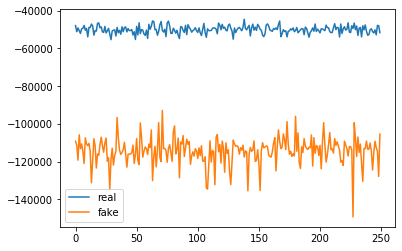

epoch: 70 [D loss: -32274.2109] [D loss test: 49963.1992] [G loss: 114582.4219] [D accuracy: 9.1313]
epoch: 71 [D loss: -31852.0684] [D loss test: 53111.5508] [G loss: 118306.7266] [D accuracy: 9.2762]
epoch: 72 [D loss: -31834.9043] [D loss test: 54608.7188] [G loss: 118992.5625] [D accuracy: 9.2752]
epoch: 73 [D loss: -31522.8242] [D loss test: 56632.2422] [G loss: 120925.0703] [D accuracy: 9.0631]
epoch: 74 [D loss: -31182.3184] [D loss test: 59591.3789] [G loss: 122517.2891] [D accuracy: 11.4153]


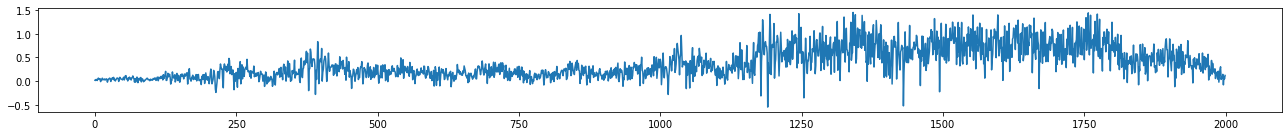

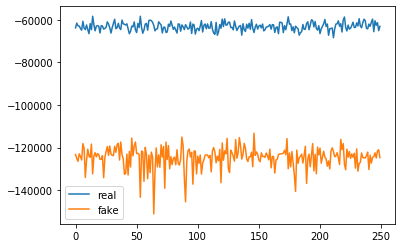

epoch: 75 [D loss: -30713.7461] [D loss test: 62965.8750] [G loss: 124932.3984] [D accuracy: 12.1935]
epoch: 76 [D loss: -30571.0703] [D loss test: 68656.4375] [G loss: 129741.7344] [D accuracy: 11.9525]


KeyboardInterrupt: 

In [10]:
wgan.n_critic = 5
wgan.train(150, db_train, db_test)

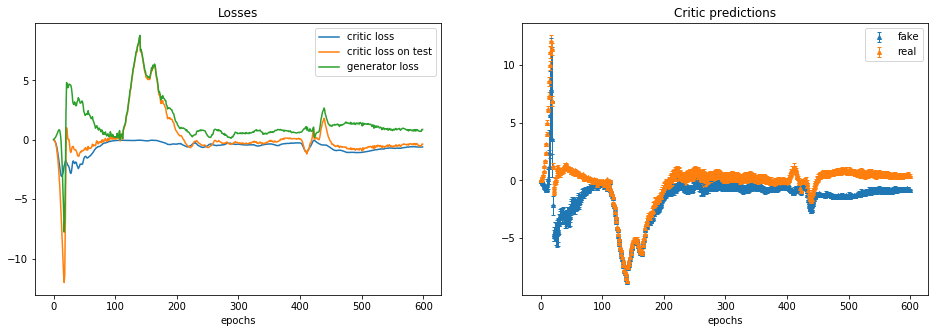

In [8]:
wgan.plot_training()